In [1]:
import cv2
import urllib3
import numpy as np
import skimage
import scipy
from scipy import ndimage
from typing import Union, Tuple

from PIL import Image

import imutils
from matplotlib import pyplot as plt

# Block 4. Feature detection, Image descriptors and BoVW

This lab explores the fundamental concepts of feature extraction and feature descriptors in computer vision. It delves into various feature detection techniques like Harris corner and LoG blob detectors, and descriptor methods like SIFT, SURF, and ORB. Additionally, the lab introduces the Bag of Visual Words model, demonstrating its application in image classification, particularly using a subset of the VOC dataset.

### Objectives:
1. **Implement Feature extraction methods**
  - **Implement Harris Corner Detector**: Understand and implement the Harris corner detection algorithm to identify corner features in images.
  - **Implement LoG Blob Detector**: Learn and apply the Laplacian of Gaussian method for blob detection in images.
2. **Implement Image feature descriptors** (Reusing part of the feature extraction code)
  - **Implement Normalized Color Histogram and Color Space Changes**: Explore color features by implementing normalized color histograms and understanding the impact of different color spaces.
  - **Use SIFT, SURF, and ORB**: Use these feature descriptors, analyze their strengths and weaknesses, and compare their performance.
3. **Provide a Pipeline for Bag of Words and Compute Results on Subset of VOC Dataset**: Develop a Bag of Visual Words model and test its efficacy in classifying images from a subset of the VOC dataset.

---

### Mandatory Questions:

1. Explain the principles behind corner detectors, specifically the Harris corner detection method. Why is it effective in identifying corners?
2. Discuss the main differences between edge detection and corner detection. Why are corners considered more robust features?
3. What are the limitations of the Harris corner detector in complex images?
4. Describe the Laplacian of Gaussian blob detector. How does it differ from edge detection?
5. Discuss the role of feature descriptors in object recognition.
6. Why are color histograms useful for image feature extraction? Describe the process of creating a normalized color histogram.
7. How does a change in color space affect feature extraction in images?
8. Explain the concepts of scale and rotation invariance in feature detection. For each algorithm (SIFT, SURF, and ORB), explain how they handle scale and rotation variations in images.
9. Compare SIFT, SURF, and ORB in terms of computational efficiency and accuracy.
10. What is the role of orientation assignment in the SIFT algorithm?
11. How does the ORB algorithm differ from SIFT and SURF in terms of feature matching?
12. How do feature descriptors contribute to the process of image stitching (for panorama images)?
13. Discuss the impact of varying lighting conditions on feature detection and description. How can these challenges be mitigated?
14. What are the key steps in constructing a Bag of Visual Words model? Explain each of them in detail.
15. In the context of the Bag of Visual Words model, explain the significance of feature quantization. Discuss on which steps it can be done and how it affects the results.


### Optional Deep Dive Questions:

1. Discuss the potential weaknesses of the LoG blob detector in real-world scenarios. Propose improvements.
2. Explore the potential of hybrid color spaces (combining properties of different color models) in improving the robustness of feature extraction for applications in varied lighting and environmental conditions.
3. Discuss the impact of varying image resolutions on the effectiveness of feature descriptors.
4. Discuss the limitations of current feature descriptors in handling occlusions and propose potential improvements.
5. Evaluate the performance of hybrid feature detectors that combine the properties of multiple algorithms (like SIFT and Harris). What are the potential benefits?
6. Analyze the role of feature extraction in content-based image retrieval systems. How do they impact the efficiency and accuracy of searches?
7. How might the Bag of Visual Words model be modified or extended to improve classification accuracy?
8. Consider the role of context in feature-based image classification. How might contextual information be incorporated into the Bag of Visual Words model?


### Exercise 1: Harris Corner Detector Implementation
**Objective**:

Implement the Harris Corner Detection algorithm to identify corner features in images.

**Guideline**:
- Load image.
- Implement the basic Harris Corner Detection algorithm.
- Apply the algorithm to the images and visualize the detected corners.
- Explore the impact of parameter changes on detection quality.
- (Optional) Implement the Harris-Laplace and the Harris-Affine improvments and compare the pros and cons of each version

**Expected Results**:
- A working Harris Corner Detection implementation.
- Visualization of corner detection in various images.


### Exercise 2: LoG Blob Detector Implementation
**Objective**:

Develop and apply the LoG method for blob detection in images, understanding its application in feature extraction.

**Guideline**:
- Select diverse images for blob detection.
- Implement the LoG Blob Detector.
- Analyze the LoG method's effectiveness.
- Compare LoG with other blob detection methods.
- (Optional) Implement your own version of other methods (DoG, DoH, ...) or design your own

**Expected Results**:
- Documented LoG Blob Detector implementation.
- Comparative analysis of blob detection results.
- Evaluation of method effectiveness and limitations.


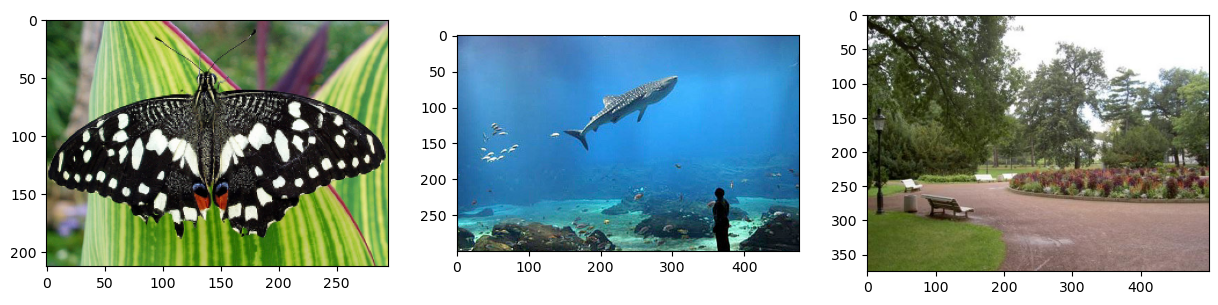

In [2]:
paths = ("extras/butterfly.png",
		 "dataset/train/aquarium/sun_acdxxtklhqaoxnqd.jpg",
		 "dataset/train/park/labelme_ivpfpphckdkblco.jpg")

imgs_rgb = [cv2.imread(path) for path in paths]
imgs_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs_rgb]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, img in enumerate(imgs_rgb):
	axs[i].imshow(img)
plt.show()

In [3]:
def gaussian_kernel(size: int, sigma: Union[int, float]) -> np.ndarray:
	'''
	Returns a gaussian kernel of the specified size and sigma.
	'''
	if isinstance(size, int):
		size = (size, size)
	h, w = size
	h = (h - 1) / 2
	w = (w - 1) / 2
	x, y = np.mgrid[-h:h+1, -w:w+1]
	normal = 1 / (2.0 * np.pi * sigma**2)
	g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
	return g

In [67]:
def laplacian_of_gaussian(image: np.ndarray,
						  kernel_size: int,
						  sigma: float,
						  zero_crossing: True) -> np.ndarray:
	"""
	Apply the Laplacian of Gaussian edge detector to the image.

	Parameters:
	image (array_like): The grayscale image.
	kernel_size (int): The size of the Gaussian kernel.
	sigma (float): The standard deviation of the Gaussian kernel.

	Returns:
	array_like: The image with the Laplacian of Gaussian edge detection applied.
	"""
	# gaussian blur
	image = image.astype(np.float64)
	g_kernel = gaussian_kernel(kernel_size, sigma)
	img_blur = cv2.filter2D(image, -1, g_kernel)

	# laplacian
	lap_kernel = np.array([[0, 1, 0],
						 [1, -4, 1],
						 [0, 1, 0]])
	img_lap = cv2.filter2D(img_blur, cv2.CV_64F, lap_kernel)
	img_lap_pad = np.pad(img_lap, 1, mode='constant', constant_values=0)

	if not zero_crossing:
		return img_lap

	# zero-crossing
	rows, cols = img_lap_pad.shape[:2]
	# min and max values in 3x3 neighborhood for each pixel
	min_map = np.minimum.reduce(list(img_lap_pad[r:rows-2+r, c:cols-2+c] for r in range(3) for c in range(3)))
	max_map = np.maximum.reduce(list(img_lap_pad[r:rows-2+r, c:cols-2+c] for r in range(3) for c in range(3)))
	# positive pixels
	pos_img = img_lap_pad[1:rows-1, 1:cols-1] > 0
	# where the min value is negative
	neg_min = min_map < 0
	neg_min[1 - pos_img] = 0
	# where the max value is positive
	pos_max = 0 < max_map
	pos_max[pos_img] = 0
	# combination of both is zero crossing
	zero_cross = neg_min + pos_max
	# rescale into 0-255
	value_scale = 255. / max(1., img_lap.max() - img_lap.min())
	values = value_scale * (max_map - min_map)
	values[1 - zero_cross] = 0.

	return values.astype(np.uint8)

In [81]:
def log_blob_detector(image: np.ndarray,
					  min_sigma: float = 1,
					  max_sigma: float = 50,
					  num_sigma: int = 10,
					  threshold: float = 0.2,
					  overlap: float = 0.5) -> np.ndarray:
	"""
	Laplacian of Gaussian blob detector.

	# Parameters
	image : Input image
	min_sigma : Minimum std for Gaussian kernel.
	max_sigma : Maximum std for Gaussian kernel.
	num_sigma : Number of values for std between min_sigma and max_sigma.
	threshold : Minimum intensity of pixels to be considered a blob.
	overlap : Maximum overlap between two blobs.

	# Returns
	keypoints: List of keypoints of blobs.
	"""
	img = image.copy()
	# If the input image is in color, convert it to grayscale
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)

	img /= 255.

	sigmas = np.linspace(min_sigma, max_sigma, num_sigma)
	imgs_log = np.zeros((*img.shape, num_sigma))

	for i, sigma in enumerate(sigmas):
		# compute ksize. From opencv: sigma = 0.3(ksize/2 - 1) + 0.8
		ksize = int(((sigma - 0.8) / 0.3 + 1) * 2)
		imgs_log[:,:,i] = -laplacian_of_gaussian(img, ksize, sigma, False) * np.mean(sigma)**2

	# compute local maxima
	local_max = skimage.feature.peak_local_max(imgs_log,
												threshold_abs=threshold,
												exclude_border=False,
												footprint=np.ones((3,3,3))).astype(np.float32)

	# corresponding sigma
	peaks_sigma = sigmas[local_max[:, -1].astype(int)]

	# replace last dimension with corresponding sigma
	local_max[:, 2] = peaks_sigma

	# Generate keypoints for each blob detected
	keypoints = []
	for blob in local_max:
		y, x, sigma = blob
		if sigma > 0:
			keypoints.append(cv2.KeyPoint(x, y, sigma*5))

	# Filter keypoints that are too close to each other
	filtered_keypoints = []
	for keypoint in keypoints:
		if all(cv2.KeyPoint_overlap(keypoint, other) < overlap for other in filtered_keypoints):
			filtered_keypoints.append(keypoint)
		
	return filtered_keypoints

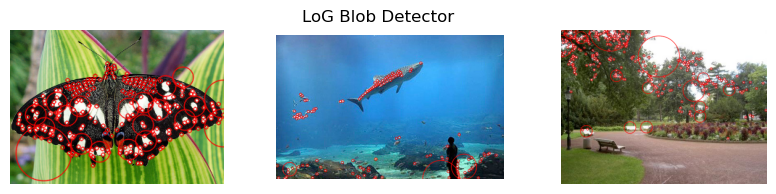

In [89]:
results = []
for img_rgb in imgs_rgb:
	keypoints = log_blob_detector(img_rgb, min_sigma=1, max_sigma=20, num_sigma=5, overlap=0.1)
	results.append(cv2.drawKeypoints(img_rgb, keypoints, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
for i, res in enumerate(results):
	axs[i].imshow(res)
	axs[i].axis('off')
fig.suptitle("LoG Blob Detector")
plt.show()

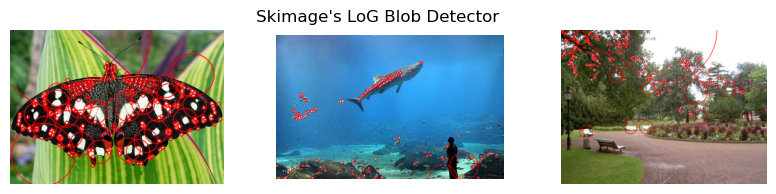

In [90]:
results_sk = []
for img_rgb in imgs_rgb:
	img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
	blobs = skimage.feature.blob_log(img_gray, overlap=0.5)
	keypoints = [cv2.KeyPoint(x, y, std*5) for y, x, std in blobs]
	results_sk.append(cv2.drawKeypoints(img_rgb, keypoints, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
for i, res in enumerate(results_sk):
	axs[i].imshow(res)
	axs[i].axis('off')
fig.suptitle("Skimage's LoG Blob Detector")
plt.show()


### Exercise 3: Normalized Color Histogram and Color Space Changes
**Objective**:
Implement normalized color histograms and explore color space transformations' impact on feature extraction.

**Guideline**:
- Implement normalized color histograms.
- Transform images into different color spaces and generate histograms.
- Analyze the impact of color space changes.

**Expected Results**:
- Color histograms in various spaces for a set of images.
- Comparative analysis on color space impact.
- Discussion on color in feature extraction and analysis.



### Exercise 4: Implementation and Analysis of SIFT, SURF, and ORB
**Objective**:
Implement and analyze SIFT, SURF, and ORB feature descriptors (use opencv implementations), understanding their pros and cons.

**Guideline**:
- Select a diverse image dataset.
- Implement SIFT and ORB algorithms. (Since SURF is patented, is optionally in the comparions)
- Apply these methods to some images.

**Expected Results**:
- Implementations of SIFT, ORB (and SURF).
- Hyperparameter analysis of each algorithm.
- Comparision of the methods

### (Optional) Exercise 4.5: Implement other image descriptor methods (motion, shape, ...)


### Exercise 5: Bag of Visual Words Pipeline and VOC Dataset Analysis
**Objective**:
Develop a BoVW model and apply it to classify images from the VOC dataset, focusing on the BoVW approach.

**Guideline**:
- Load the VOC dataset.
- Implement the BoVW model.
- Apply the model to the dataset for classification.
- Evaluate the model's performance.

**Expected Results**:
- Implementation of the Bag of Visual Words model.
- Application of the model for image classification.
- Evaluation of the model's performance.

**Optional Enhancements**:
- Experiment with different clustering algorithms for codebook generation in the BoVW model.

### Step 1: Data Loading
- **Objective**: Load images from each class into a format suitable for processing.
- **Guide**: Use a library like OpenCV or PIL in Python to load images. Iterate over the folders, loading each image and storing it with its class label.

### Step 2: Feature Extraction
- **Objective**: Extract features from each image to represent its content.
- **Guide**: Apply a feature descriptor to each image. This transforms the image into a set of features. Examples can be SIFT, SURF, Color histogram, etc

### Step 3: Building the Vocabulary (Codebook)
- **Objective**: Create a vocabulary of visual words (features) that represents the dataset.
- **Guide**: Cluster the extracted features across all images using any clustering algorithm. Each cluster center is a visual word.

### Step 4: Feature Encoding
- **Objective**: Encode each image as a frequency histogram of visual words.
- **Guide**: For each image, count how many features fall into each cluster (visual word) and create a histogram.

### Step 5: Classifier Training
- **Objective**: Train a machine learning model to classify the images.
- **Guide**: Use the histograms as input features for a classifier. Any supervised classifier can be used (SVM, Random Forest, KNN, Neural nets, ...)

### Step 6: Model Evaluation
- **Objective**: Evaluate the performance of the classifier.
- **Guide**: Use a confusion matrix to visualize the performance and extract metrics.